# Two moment retrieval

An idealized cloud model is applied to investigate the potential of combining RADAR with passive microwave and sub-millimeter observations to retrieve distributions of ice hydrometeors in the atmospheric column.

In [1]:
%env LIRAS_PATH=/old/projects/LIRAS/Development/liras
%env ARTS_BUILD_PATH=/home/simonpf/build/arts_fast

env: LIRAS_PATH=/old/projects/LIRAS/Development/liras
env: ARTS_BUILD_PATH=/home/simonpf/build/arts_fast


### Particle size distribution

For the analysis, a modified version of the PSD used for the DARDAR retrievals is used. Instead of $N_0^*$ and $D_m$, this version uses mass density $m$ and $D_m$ as free parameters of the particle size distribution.

In [2]:
from parts.scattering.psd.d14 import D14
d14 = D14(-0.26, 4.0, 917.0)

Loading ARTS API from: /home/simonpf/build/arts_fast/src/libarts_api.so


### Frozen hydrometeors

For these simplified simulations we assume that only one type of frozen hydrometeors is present in the atmosphere. We model this one using the 8-column aggregate habit with the PSD defined above.

In [5]:
from mcrf.liras import ice_shape, ice_shape_meta
from parts.scattering import ScatteringSpecies

ice = ScatteringSpecies("ice", d14, ice_shape, ice_shape_meta)

As background atmosphere the same model as for the retrievals is used.

In [6]:
from parts.atmosphere            import Atmosphere1D
from parts.atmosphere.absorption import O2, N2, H2O
from parts.atmosphere.surface    import Tessem
from parts.simulation            import ArtsSimulation
from mcrf.liras.model_data       import MeanModelDataProvider

absorbers  = [O2(), N2(), H2O()]
scatterers = [ice]
atmosphere = Atmosphere1D(absorbers = absorbers,
                          scatterers = scatterers,
                          surface = Tessem())

data_provider = MeanModelDataProvider(99)

### A simplified cloud model

The idealized cloud model used for this study assumes a 2km-thick, homogeneous cloud layer at a given height.

In [8]:
import numpy as np
from mcrf.liras.model_data import MeanModelDataProvider
from parts.data_provider import CombinedProvider

class HomogeneousCloud:
    def __init__(self, height, thickness, moment_names, ranges):
        self.height       = height
        self.thickness    = thickness
        self.ranges       = ranges
        self.z            = data_provider.get_altitude()
        self.x            = np.logical_and(self.z >= self.height - 0.5 * self.thickness,
                                           self.z < self.height + 0.5 * self.thickness).astype(np.float64)
        
        name = "get_ice_" + moment_names[0]
        self.__dict__[name] = self.get_first_moment
        
        name = "get_ice_" + moment_names[1]
        self.__dict__[name] = self.get_second_moment
        
    def get_first_moment(self, i, j):
        return self.x * self.ranges[0][i]
    
    def get_second_moment(self, i, j):
        return self.x * self.ranges[1][j]

In [9]:
ranges = [np.logspace(-6, -3, 41),
          np.linspace(0.0, 1e-3, 41)]
homogeneous_cloud = HomogeneousCloud(10e3, 5e3, ice.psd.moment_names, ranges)

In [10]:
homogeneous_cloud.ranges[0][21]

3.758374042884443e-05

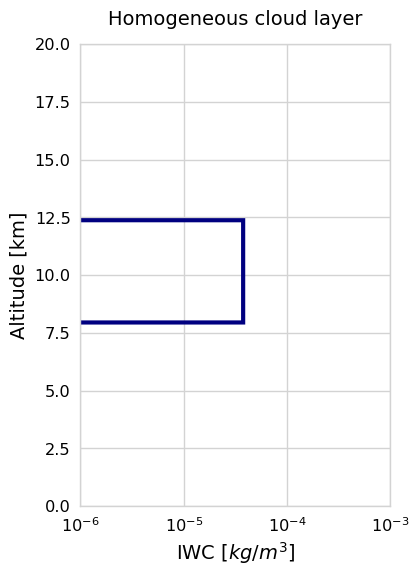

In [13]:
from mcrf.utils.setup_notebook import *
md = homogeneous_cloud.get_ice_mass_density(21, 21)
z = data_provider.get_altitude() / 1e3

f, ax = plt.subplots(1, 1, figsize = (4, 6))
ax.plot(md, z, c = "navy", lw = 3)
ax.set_xscale("log")
ax.set_xlim([1e-6, 1e-3])
ax.set_title("Homogeneous cloud layer")
ax.set_xlabel("IWC [$kg / m^3$]")
ax.set_ylabel("Altitude [km]")
ax.set_ylim([0, 20])
f.savefig("../../plots/simple_cloud.pdf", bbox_inches = "tight")

In [16]:
from mcrf.sensors import lcpr, mwi, ici
simulation = ArtsSimulation(atmosphere = atmosphere,
                            sensors = [lcpr, mwi, ici],
                            data_provider = CombinedProvider(homogeneous_cloud, data_provider))

In [17]:
simulation.setup(verbosity = 0)

668.2 89.0


In [ ]:
from tqdm import trange

y_lcpr = []
y_mwi   = []
y_ici   = []

for i in trange(41):
    for j in range(41):
        simulation.run(i, j)
        y_lcpr += [np.copy(lcpr.y.ravel())]
        y_mwi  += [np.copy(mwi.y.ravel())]
        y_ici  += [np.copy(ici.y.ravel())]


 44%|████▍     | 18/41 [2:34:45<3:17:49, 516.06s/it]

In [ ]:
simulation.run(0, 0)

In [13]:
y_lcpr = np.stack(y_lcpr).reshape(41, 41, -1)
y_mwi  = np.stack(y_mwi).reshape(41, 41, -1)
y_ici  = np.stack(y_ici).reshape(41, 41, -1)

In [14]:
np.savez("ys.npy", y_lcpr, y_mwi, y_ici)

In [26]:
results.shape

(41, 41, 61)

In [28]:
results = np.load("../ys.npy")
y_lcpr = results[:, :, :39]
y_mwi = results[:, :, 39:(39 + 11)]
y_ici = results[:, :, (39 + 11) :]
(y_lcpr.shape, y_mwi.shape, y_ici.shape)

((41, 41, 39), (41, 41, 11), (41, 41, 11))

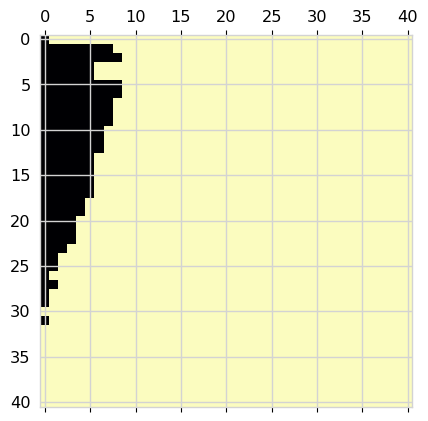

In [29]:
dy = y_mwi[:, :, 1] - y_mwi[0, 0, 1]
plt.matshow(dy < 0)

FileNotFoundError: [Errno 2] No such file or directory: '../plots/contours.pdf'

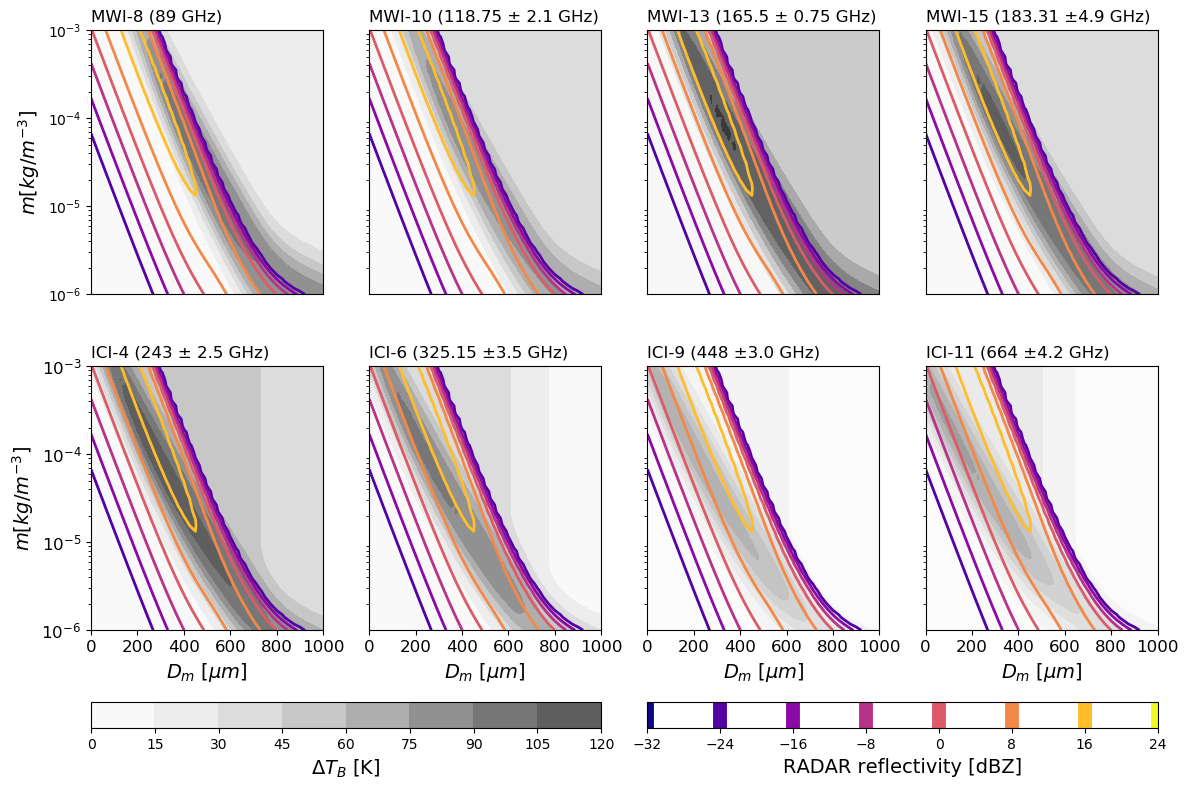

In [32]:
%matplotlib inline
from mcrf.utils import setup_notebook
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt


channels_mwi = [0, 2, 5, 8]
names_mwi = ["MWI-8 (89 GHz)", "MWI-10 (118.75 ± 2.1 GHz)", "MWI-13 (165.5 ± 0.75 GHz)",
            "MWI-15 (183.31 ±4.9 GHz)"]
channels_ici = [3, 5, 8, 10]
names_ici    = ["ICI-4 (243 ± 2.5 GHz)", "ICI-6 (325.15 ±3.5 GHz)", "ICI-9 (448 ±3.0 GHz)", "ICI-11 (664 ±4.2 GHz)"]

gs = GridSpec(3, 4, height_ratios = [1.0, 1.0, 0.1])
f = plt.figure(figsize = (12, 8))

m  = np.logspace(-6, -3, 41)
dm = np.linspace(0, 1e-3, 41) * 1e6

norm = Normalize(vmin = 0, vmax = 160)
for i, (c, n) in enumerate(zip(channels_mwi, names_mwi)):
    ax = plt.subplot(gs[0,i])
    y = y_mwi[:, :, c]
    y0 = y_mwi[0, 0, c]
    dy = y0 - y
    dy = np.maximum(dy, 0.0)
    cntr_p = ax.contourf(dm, m, dy, cmap = "Greys", norm = norm)
    ax.contour(dm, m, y_lcpr[:, :, 20], cmap = "plasma", linewidths = [2.0])
    ax.set_xlim([0.0, 1e3])
    ax.set_yscale("log")
    ax.set_title(n, loc = "left")
    
    if i == 0:
        ax.set_ylabel("$m [kg / m^{-3}]$", fontsize = 14)
    
    ax.set_xticks([])
    if i > 0:
        ax.set_yticks([])
    
for i, (c, n) in enumerate(zip(channels_ici, names_ici)):
    ax = plt.subplot(gs[1,i])
    y = y_ici[:, :, c]
    y0 = y_ici[0, 0, c]
    dy = y0 - y
    dy = np.maximum(dy, 0.0)
    ax.contourf(dm, m, dy, cmap = "Greys", norm = norm)
    cntr_r = ax.contour(dm, m, y_lcpr[:, :, 20], cmap = "plasma", linewidths = [2.0])
    ax.set_xlim([0.0, 1e3])
    ax.set_xlabel("$D_m$ [$\mu m$]", fontsize = 14)
    ax.set_yscale("log")
    ax.set_title(n, loc = "left")
    
    if i == 0:
        ax.set_ylabel("$m [kg / m^{-3}]$", fontsize = 14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(12)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
        
    if i > 0:
        ax.set_yticks([])
    
ax = plt.subplot(gs[-1, :2])
cbar = plt.colorbar(cntr_p, cax = ax, label = "$\Delta T_B$ [K]", orientation = "horizontal")
cbar.ax.xaxis.label.set_fontsize(14)
ax = plt.subplot(gs[-1, 2:])
cntr_r.linewidths = [6.0]
cbar = plt.colorbar(cntr_r, cax = ax, label = "RADAR reflectivity [dBZ]", orientation = "horizontal")
cbar.ax.xaxis.label.set_fontsize(14)
lc = ax.get_children()[0]
lc.set_linewidths([10.0])

plt.tight_layout()
plt.savefig("../plots/contours.pdf", bbox_inches = "tight")

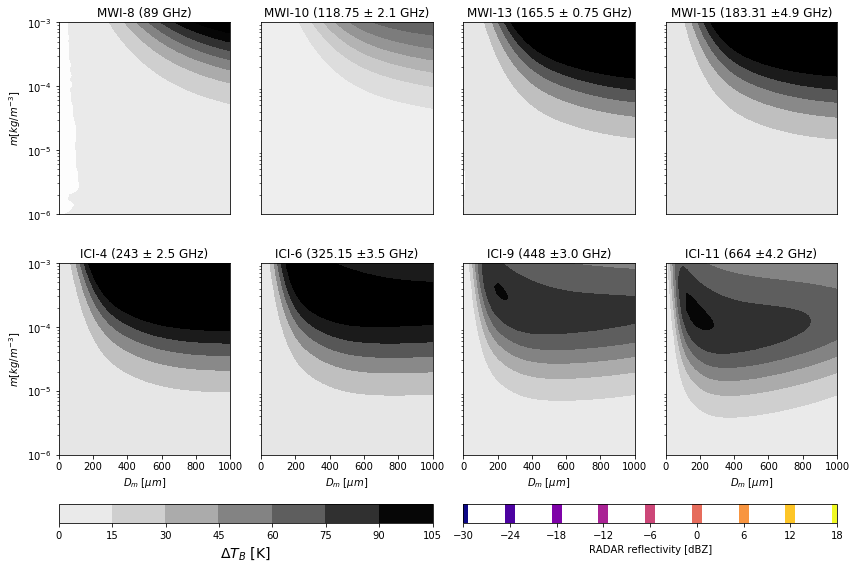

In [72]:
%matplotlib inline
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt


channels_mwi = [0, 2, 5, 8]
names_mwi = ["MWI-8 (89 GHz)", "MWI-10 (118.75 ± 2.1 GHz)", "MWI-13 (165.5 ± 0.75 GHz)",
            "MWI-15 (183.31 ±4.9 GHz)"]
channels_ici = [3, 5, 8, 10]
names_ici    = ["ICI-4 (243 ± 2.5 GHz)", "ICI-6 (325.15 ±3.5 GHz)", "ICI-9 (448 ±3.0 GHz)", "ICI-11 (664 ±4.2 GHz)"]

gs = GridSpec(3, 4, height_ratios = [1.0, 1.0, 0.1])
f = plt.figure(figsize = (12, 8))

m  = np.logspace(-6, -3, 41)
dm = np.linspace(0, 1e-3, 41) * 1e6

norm = Normalize(vmin = -10, vmax = 100)
for i, (c, n) in enumerate(zip(channels_mwi, names_mwi)):
    ax = plt.subplot(gs[0,i])
    y = y_mwi[:, :, c]
    y0 = y_mwi[0, 0, c]
    dy = y0 - y
    cntr = ax.contourf(dm, m, dy, cmap = "Greys", norm = norm)
    #ax.contour(dm, m, y_lcpr[:, :, 20], cmap = "plasma", linewidths = [2.0])
    ax.set_xlim([0.0, 1e3])
    ax.set_yscale("log")
    ax.set_title(n)
    
    if i == 0:
        ax.set_ylabel("$m [kg / m^{-3}]$")
    
    ax.set_xticks([])
    if i > 0:
        ax.set_yticks([])
    
for i, (c, n) in enumerate(zip(channels_ici, names_ici)):
    ax = plt.subplot(gs[1,i])
    y = y_ici[:, :, c]
    y0 = y_ici[0, 0, c]
    dy = y0 - y
    cntr_p = ax.contourf(dm, m, dy, cmap = "Greys", norm = norm)
    #cntr_r = ax.contour(dm, m, y_lcpr[:, :, 20], cmap = "plasma", linewidths = [2.0])
    ax.set_xlim([0.0, 1e3])
    ax.set_xlabel("$D_m$ [$\mu m$]")
    ax.set_yscale("log")
    ax.set_title(n)
    
    if i == 0:
        ax.set_ylabel("$m [kg / m^{-3}]$")
        
    if i > 0:
        ax.set_yticks([])
    
ax = plt.subplot(gs[-1, :2])
cbar = plt.colorbar(cntr_p, cax = ax, label = "$\Delta T_B$ [K]", orientation = "horizontal")
ax.xaxis.label.set_fontsize(14)
ax = plt.subplot(gs[-1, 2:])
cntr_r.linewidths = [6.0]
cbar = plt.colorbar(cntr_r, cax = ax, label = "RADAR reflectivity [dBZ]", orientation = "horizontal")
lc = ax.get_children()[0]
lc.set_linewidths([10.0])

plt.tight_layout()
plt.savefig("../plots/contours_0.pdf", bbox_inches = "tight")